# Deep Learning models for College Football Game Prediction

For background on the problem and prior models to solve the problem, see the "Prediction with Regression Models" notebook.

Recall that our Model 2 which takes in game stats and outputs the predicted score was highly accurate using a regression based approach. As a result, we will focus on utilizing deep learning for Models 1 and 3 only.
Recall that both Models 1 and 3 take in historical data for the teams in a given game and output the predicted stats and score, respectively, for this next game. One question is how big of an impact does a team's historical performance impact future performance, and at what time scale? For instance, it may turn out that the performance of only the past week or two is important, but perhaps the entire past year is all similarly important. As a result of these time-varying questions, we were motivated to use a long-short-term memory deep learning model for Models 1 and 3. In this notebook we will show the results of such modelling approaches.

## Model 1
Recall that in this model, we start with input the recent historical stats of each teams in a game and predict the stats for both teams in their pending matchup. 

In [6]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None 

In [2]:
games_df = pd.read_csv("clean_games_with_opp.csv", index_col=0)
games_df.reset_index(drop=True, inplace=True)
games_df.head()

,school,school_id,points,fumblesRecovered,rushingTDs,passingTDs,kickReturnYards,kickReturnTDs,kickReturns,kickingPoints,...,opposing_rushingTDs,opposing_points,side,thirdDownConverts,thirdDownAttempts,fourthDownConverts,fourthDownAttempts,completions,passAttempts,passCompletionPercentage
0,Navy,2426,17,0.0,2.0,0.0,64.0,0.0,4.0,5.0,...,1.0,34,A,4.0,12.0,1.0,1.0,2.0,4.0,0.500000
1,UAB,5,48,1.0,4.0,2.0,64.0,0.0,2.0,12.0,...,1.0,10,A,9.0,14.0,0.0,0.0,13.0,20.0,0.650000
2,UMass,113,7,0.0,0.0,1.0,95.0,0.0,4.0,1.0,...,2.0,30,A,3.0,11.0,1.0,1.0,9.0,22.0,0.409091
3,UCF,2116,24,1.0,2.0,1.0,142.0,0.0,5.0,6.0,...,1.0,26,A,5.0,13.0,2.0,2.0,12.0,22.0,0.545455
4,Houston,248,7,1.0,1.0,0.0,89.0,0.0,6.0,1.0,...,3.0,27,A,4.0,16.0,4.0,4.0,25.0,50.0,0.500000


We process out data that is missing or not in the desired numerical format.

In [3]:
# Dropping all columns with more than 25 nulls, then dropping the individual rows that have nulls
x = games_df.isna().sum().to_dict()
column_drop = []

for k, v in x.items():
    if v > 25 :
        column_drop.append(k)

# Additionally, these columns are weird formats or already covered by other variables (ie the possession stuff)
extend_list = ['completionAttempts','totalPenaltiesYards','possessionTime','possession_minutes','possession_seconds','year','week','school','opposing_points']

#column_drop.extend(extend_list)
column_drop = column_drop + extend_list

games_df.drop(columns=column_drop, inplace = True)
games_df.dropna(axis = 0, inplace = True)

games_df = games_df.select_dtypes(exclude=["object"])

games_df = games_df.sort_values("id")

We again set the memory (number of past games to remember) equal to 12, which roughly equates to 1 full season.

In [4]:
memory = 12
teams = set(games_df["school_id"])

teams_dict = {}
for team in teams:
    temp_df = games_df[games_df["school_id"] == team].sort_values("id")
    teams_dict[team] = temp_df.reset_index(drop=True)

In [7]:
X = []
y = []
points = []
for team in teams:
    team1_df = teams_dict[team]
    
    # loop over all possible games for a given team with enough prior games
    for i in range(memory, len(team1_df)):
        # find the two teams participating in the game
        game_id = team1_df.loc[i]["id"]
        both_teams_ids = games_df[games_df["id"] == game_id]["school_id"]
        both_teams_ids = list(both_teams_ids)

        # throw out some odd cases where  there was only data for one of the teams in a given game
        if len(both_teams_ids) != 2:
            continue
        #print(f"both teams are {both_teams_ids}")
 
        # extract the dataframes for the two teams, find which game it was for them
        t1_df = teams_dict[both_teams_ids[0]]#.loc[i-memory:i+1]
        t2_df = teams_dict[both_teams_ids[1]]#.loc[i-memory:i+1]

        t1_gamen = np.where(t1_df["id"] == game_id)[0][0]
        t2_gamen = np.where(t2_df["id"] == game_id)[0][0]

        # check to make sure that both teams have enough games in the past
        if t1_gamen < memory or t2_gamen < memory:
            continue
        
        # extract the games in recent history, dropping columns that don't go into the data
        t1_df = t1_df.loc[t1_gamen-memory:t1_gamen]#+1]
        t1_points = t1_df["points"].to_numpy()[-1]
        t2_df = t2_df.loc[t2_gamen-memory:t2_gamen]#+1]
        t2_points = t2_df["points"].to_numpy()[-1]
        t1_df.drop(columns=["id", "school_id", "points"], inplace=True)
        t2_df.drop(columns=["id", "school_id", "points"], inplace=True)

        t1_array = np.array(t1_df)
        t2_array = np.array(t2_df)

        # break the arrays into past games and current game to go into training and test set
        t1_past = t1_array[0:-1]
        t1_present = t1_array[-1]
        t2_past = t2_array[0:-1]
        t2_present = t2_array[-1]


        X.append(np.hstack([t1_past, t2_past]))
        y.append(np.hstack([t1_present, t2_present]))
        points.append(np.array([t1_points, t2_points]))
        
X = np.array(X)
y = np.array(y)
points = np.array(points)
print(X.shape, y.shape, points.shape)


(12742, 12, 56) (12742, 56) (12742, 2)


Now we scale the inputs. For Model 1 we scale the outputs as well to homogenize the impact of errors when analyzing model performance.

In [8]:

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X1_train, X1_test, y1_train, y1_test = train_test_split(X, y, test_size=0.25, random_state=42)

n_train_samples = len(X1_train)
n_test_samples = len(X1_test)

scaler = StandardScaler()
X1_train_flat = np.reshape(X1_train, (n_train_samples, -1))
X1_test_flat = np.reshape(X1_test, (n_test_samples, -1))
scaler.fit(X1_train_flat)
X1_train_scaled = scaler.transform(X1_train_flat)
X1_test_scaled = scaler.transform(X1_test_flat)
X1_train_scaled = np.reshape(X1_train_scaled, (n_train_samples, memory, -1))
X1_test_scaled = np.reshape(X1_test_scaled, (n_test_samples, memory, -1))

scaler2 = StandardScaler()
scaler2.fit(y1_train)
y1_train_scaled = scaler2.transform(y1_train)
y1_test_scaled = scaler2.transform(y1_test)


Now we initialize the Deep Learning model for Model 1. We will use a straightforward LSTM architecture with 3 LSTM layers followed by 1 dense layer. We settled on 3 layers because (1) this is a standard number in the literature, but more importantly (2) with some testing there was notable improvement from 2 to 3 layers, but not from 3 to 4.

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

model1 = Sequential()

model1.add(LSTM(units=X.shape[2], return_sequences=True, input_shape=(X1_train_scaled.shape[1], X1_train_scaled.shape[2])))
model1.add(Dropout(0.2))

model1.add(LSTM(units=X.shape[2], return_sequences=True))
model1.add(Dropout(0.2))

model1.add(LSTM(units=X.shape[2]))
model1.add(Dropout(0.2))

model1.add(Dense(units=y.shape[1]))

model1.summary()
model1.compile(loss="mean_squared_error", optimizer="adam")




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 56)            25312     
                                                                 
 dropout (Dropout)           (None, 12, 56)            0         
                                                                 
 lstm_1 (LSTM)               (None, 12, 56)            25312     
                                                                 
 dropout_1 (Dropout)         (None, 12, 56)            0         
                                                                 
 lstm_2 (LSTM)               (None, 56)                25312     
                                                                 
 dropout_2 (Dropout)         (None, 56)                0         
                                                                 
 dense (Dense)               (None, 56)               

We now train the model:

In [10]:
from keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='loss', patience=5)

model1.fit(X1_train_scaled, y1_train_scaled, epochs=200, verbose=True, callbacks=[callback])

Epoch 1/200

299/299 [==============================] - 9s 13ms/step - loss: 0.9116
Epoch 2/200
299/299 [==============================] - 4s 13ms/step - loss: 0.8688
Epoch 3/200
299/299 [==============================] - 4s 13ms/step - loss: 0.8504
Epoch 4/200
299/299 [==============================] - 4s 13ms/step - loss: 0.8349
Epoch 5/200
299/299 [==============================] - 4s 13ms/step - loss: 0.8164
Epoch 6/200
299/299 [==============================] - 4s 13ms/step - loss: 0.7976
Epoch 7/200
299/299 [==============================] - 4s 13ms/step - loss: 0.7796
Epoch 8/200
299/299 [==============================] - 4s 13ms/step - loss: 0.7633
Epoch 9/200
299/299 [==============================] - 4s 13ms/step - loss: 0.7454
Epoch 10/200
299/299 [==============================] - 4s 13ms/step - loss: 0.7295
Epoch 11/200
299/299 [==============================] - 4s 13ms/step - loss: 0.7148
Epoch 12/200
299/299 [==============================] - 4s 13ms/step - loss: 0.6996


Now we analyze the results:

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y1_pred = model1.predict(X1_test_scaled)

print(f"MSE for Model 1 is: {mean_squared_error(y1_test_scaled, y1_pred)}")

100/100 [==============================] - 2s 5ms/step
MSE for Model 1 is: 0.5863021138409723


Recall that our best Regression model using Lasso Regression only achieved a MSE of ~0.84. Thus, there is a notable improvement with the Deep Learning approach. The more notable improvement however will come into play in Model 3:

## Model 3
We now generate and test the LSTM network for Model 3, which takes in historical stats of each team in a game and directly tries to predict the score of that game. We first perform out train-test split and scaling:

In [13]:
y3 = points
X3_train, X3_test, y3_train, y3_test = train_test_split(X, y3, test_size=0.25, random_state=42)

n_train_samples = len(X3_train)
n_test_samples = len(X3_test)

scaler = StandardScaler()
X3_train_flat = np.reshape(X3_train, (n_train_samples, -1))
X3_test_flat = np.reshape(X3_test, (n_test_samples, -1))
scaler.fit(X3_train_flat)
X3_train_scaled = scaler.transform(X3_train_flat)
X3_test_scaled = scaler.transform(X3_test_flat)
X3_train_scaled = np.reshape(X3_train_scaled, (n_train_samples, memory, -1))
X3_test_scaled = np.reshape(X3_test_scaled, (n_test_samples, memory, -1))

scaler2 = StandardScaler()
scaler2.fit(y3_train)
y3_train_scaled = scaler2.transform(y3_train)
y3_test_scaled = scaler2.transform(y3_test)

In [29]:
# Define y3 to be the points array
y3 = points

# Construct the three-layer model
model3 = Sequential()

model3.add(LSTM(units=X.shape[2], return_sequences=True, input_shape=(X3_train_scaled.shape[1], X3_train_scaled.shape[2])))
model3.add(Dropout(0.1))

model3.add(LSTM(units=X.shape[2], return_sequences=True))
model3.add(Dropout(0.1))

model3.add(LSTM(units=X.shape[2]))
model3.add(Dropout(0.1))

model3.add(Dense(units=y3.shape[1]))

model3.summary()

# Recall for the scores we want MAE instead of MSE
model3.compile(loss="mean_squared_error", optimizer="adam")

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 12, 56)            25312     
                                                                 
 dropout_12 (Dropout)        (None, 12, 56)            0         
                                                                 
 lstm_16 (LSTM)              (None, 12, 56)            25312     
                                                                 
 dropout_13 (Dropout)        (None, 12, 56)            0         
                                                                 
 lstm_17 (LSTM)              (None, 56)                25312     
                                                                 
 dropout_14 (Dropout)        (None, 56)                0         
                                                                 
 dense_5 (Dense)             (None, 2)                

In [33]:
model3.fit(X3_train_scaled, y3_train_scaled, epochs=200, verbose=True)

Epoch 1/200
299/299 [==============================] - 4s 12ms/step - loss: 0.0369
Epoch 2/200
299/299 [==============================] - 4s 13ms/step - loss: 0.0365
Epoch 3/200
299/299 [==============================] - 4s 13ms/step - loss: 0.0361
Epoch 4/200
299/299 [==============================] - 4s 13ms/step - loss: 0.0364
Epoch 5/200
299/299 [==============================] - 4s 13ms/step - loss: 0.0352
Epoch 6/200
299/299 [==============================] - 4s 13ms/step - loss: 0.0353
Epoch 7/200
299/299 [==============================] - 4s 13ms/step - loss: 0.0351
Epoch 8/200
299/299 [==============================] - 4s 13ms/step - loss: 0.0350
Epoch 9/200
299/299 [==============================] - 4s 13ms/step - loss: 0.0349
Epoch 10/200
299/299 [==============================] - 4s 13ms/step - loss: 0.0359
Epoch 11/200
299/299 [==============================] - 4s 13ms/step - loss: 0.0346
Epoch 12/200
299/299 [==============================] - 4s 13ms/step - loss: 0.0343
E

Now we analyze the results:

In [34]:
y3_pred_scaled = model3.predict(X3_test_scaled)
y3_pred = scaler2.inverse_transform(y3_pred_scaled)

print(f"MAE for Model 3 is: {mean_absolute_error(y3_test, y3_pred)}")

100/100 [==============================] - 0s 5ms/step
MAE for Model 3 is: 3.9016220766863317


We see how accurate the model was in predicting the winner of a given game:

In [35]:
real_games = []
pred_games = []
for i in range(len(y3_test)):
    # determine which models predicted team 1 to win
    if y3_test[i][0] > y3_test[i][1]:
        real_games.append(1)
    else:
        real_games.append(0)

    if y3_pred[i][0] > y3_pred[i][1]:
        pred_games.append(1)
    else:
        pred_games.append(0)
    
# Sum up the number of times the model predicted the wrong winner
incorrect_games = np.sum(np.abs(np.array(pred_games) - np.array(real_games)))
correct_games = len(y3_test) - incorrect_games

print(f"Correct games is: {correct_games} out of {len(y3_test)}, pct correct is {(correct_games)/len(y3_test)}.")

Correct games is: 2874 out of 3186, pct correct is 0.9020715630885122.


In [36]:
model_residuals = y3_test - y3_pred

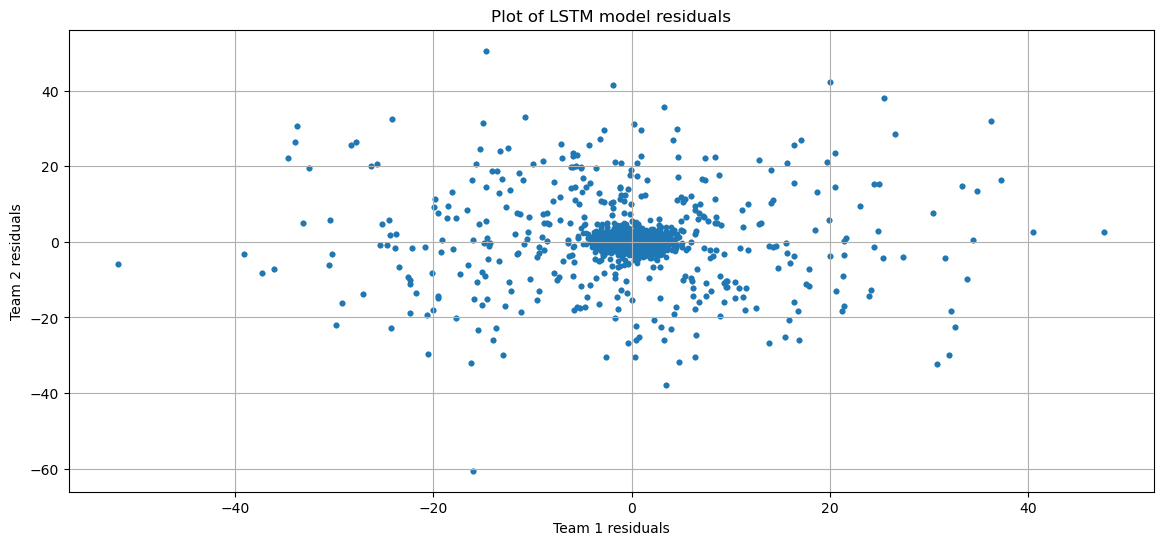

In [38]:
import matplotlib.pyplot as plt

# Plotting residuals
plt.figure(figsize=(14,6))

plt.scatter(x = model_residuals[:,0], y = model_residuals[:,1], s=10)
plt.title('Plot of LSTM model residuals')
plt.xlabel('Team 1 residuals')
plt.ylabel('Team 2 residuals')
plt.grid()
plt.show()

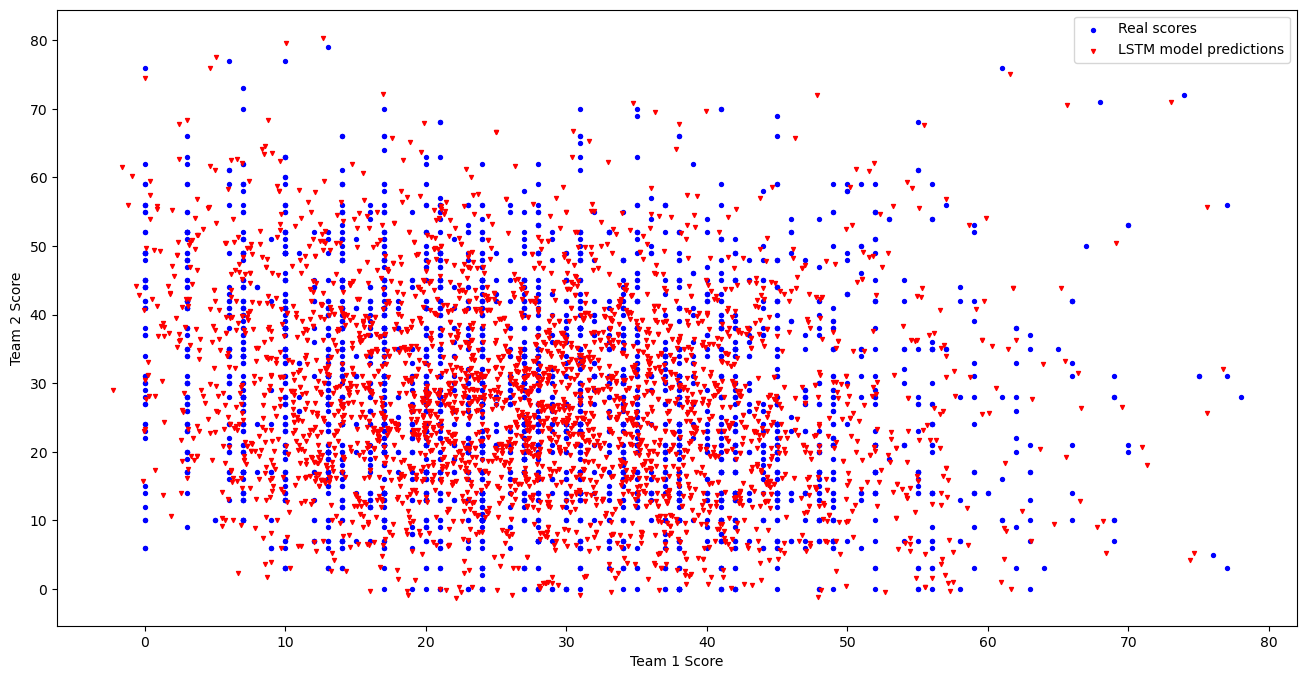

In [39]:
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(111)

ax1.scatter(y3_test[:,0], y3_test[:,1], s=8, c='b', marker="o", label='Real scores')
ax1.scatter(y3_pred[:,0], y3_pred[:,1], s=8, c='r', marker="v", label='LSTM model predictions')

plt.legend(loc='upper right')
plt.xlabel('Team 1 Score')
plt.ylabel('Team 2 Score')
plt.show()

In [41]:
print(f"MAE for Model 3 is: {mean_absolute_error(y3_test, y3_predr)}")

MAE for Model 3 is: 3.876177024482109


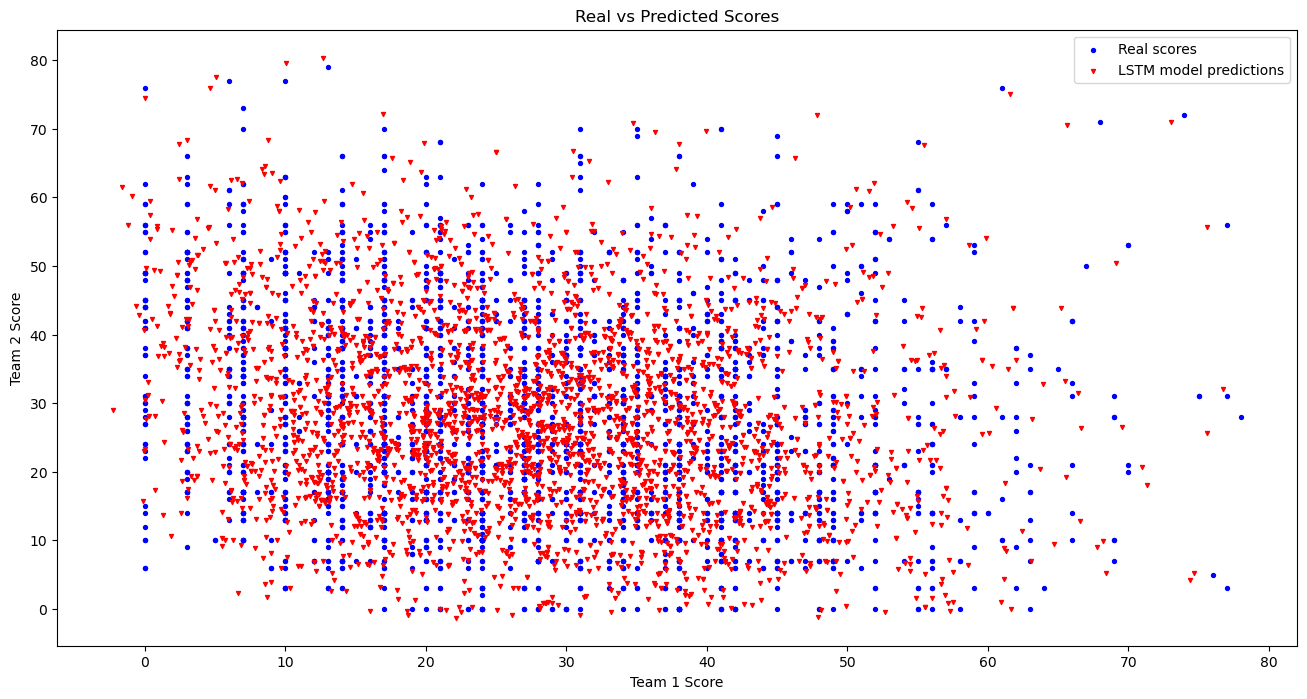

In [44]:
y3_predr = np.round(y3_pred)

fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(111)

ax1.scatter(y3_test[:,0], y3_test[:,1], s=8, c='b', marker="o", label='Real scores')
ax1.scatter(y3_pred[:,0], y3_pred[:,1], s=8, c='r', marker="v", label='LSTM model predictions')

plt.legend(loc='upper right')
plt.xlabel('Team 1 Score')
plt.ylabel('Team 2 Score')
plt.title("Real vs Predicted Scores")
plt.show()

## Restricting to Power 5 games

In [25]:
print(teams)

{2, 2050, 5, 6, 2567, 8, 2569, 9, 2571, 2572, 12, 13, 16, 2065, 2579, 21, 2582, 23, 24, 25, 26, 3101, 30, 2083, 36, 2084, 38, 2598, 41, 43, 47, 48, 2097, 50, 52, 55, 57, 58, 2619, 59, 61, 2110, 2617, 2623, 62, 66, 2115, 2116, 68, 2628, 2117, 70, 2633, 2630, 2635, 2636, 77, 2638, 79, 2127, 2641, 2634, 2643, 2132, 84, 2640, 87, 2649, 2653, 93, 2655, 96, 97, 98, 99, 2142, 103, 107, 113, 2674, 2678, 119, 120, 2169, 2681, 127, 130, 2692, 2181, 135, 2184, 142, 145, 2193, 147, 2197, 150, 151, 152, 153, 154, 2711, 2199, 2717, 158, 2710, 160, 155, 2210, 164, 166, 167, 2729, 2226, 2229, 2230, 183, 2747, 189, 2751, 193, 194, 2755, 2241, 197, 2754, 2247, 195, 201, 202, 204, 2771, 213, 2261, 218, 221, 222, 227, 228, 2277, 231, 233, 235, 236, 238, 239, 149, 2287, 242, 2803, 245, 2294, 248, 249, 2296, 251, 252, 253, 254, 256, 2305, 258, 259, 257, 2309, 2306, 264, 265, 2320, 275, 276, 277, 278, 2837, 2329, 282, 2335, 290, 2341, 295, 2348, 301, 302, 304, 2198, 309, 311, 322, 324, 326, 328, 2377, 331, 3

In [43]:
games_df = pd.read_csv("clean_games_with_opp.csv", index_col=0)
games_df.reset_index(drop=True, inplace=True)
print(set(games_df["school"]))

{'Boise State', 'Abilene Christian', 'South Dakota', 'Colgate', 'Southeastern Louisiana', 'UCF', 'South Alabama', 'Rhode Island', 'Pittsburgh', 'Arkansas-Pine Bluff', 'Georgia State', 'Western Michigan', 'Miami (OH)', 'Eastern Michigan', 'Nebraska', 'Oregon', 'Arizona State', 'Rutgers', 'Syracuse', 'Merrimack', 'Montana State', 'Savannah State', 'Campbell', 'Delaware State', 'Central Arkansas', 'North Dakota', 'Iowa', 'Gardner-Webb', 'Elon', 'Jacksonville State', 'North Carolina Central', 'Notre Dame', 'Minnesota', 'Utah', 'Liberty', 'Rice', 'Bowling Green', 'Miami', 'Howard', 'Georgia Tech', 'Memphis', 'Southern Utah', 'East Tennessee State', 'Nicholls', 'Boston College', 'Texas', 'Central Michigan', 'New Mexico State', 'San Diego State', 'Marshall', 'Youngstown State', 'Arizona', 'Lafayette', 'Montana', 'Virginia Tech', 'Kansas State', 'Old Dominion', 'Kennesaw State', 'Ohio', 'Austin Peay', 'Tennessee', 'San Diego', 'Coastal Carolina', 'Virginia', 'Eastern Kentucky', 'Nevada', 'Dela

Now we define the power 5 only teams, and extract only their data. This corresponds to the "bigger and better" schools.

In [44]:
p5_teams = {'Pittsburgh', 'Nebraska', 'Oregon', 'Arizona State', 'Rutgers', 'Syracuse', 'Iowa', 'Notre Dame', 'Minnesota', 'Utah', 'Miami', 'Georgia Tech', 'Boston College', 'Texas', 'Arizona', 'Virginia Tech', 'Kansas State', 'Tennessee', 'Virginia', 'Clemson', 'TCU', 'Ole Miss', 'Duke', 'Florida State', 'Texas A&M', 'Louisville', 'Michigan State', 'Stanford', 'Washington', 'Colorado', 'NC State', 'Penn State', 'Missouri', 'West Virginia', 'Texas Tech', 'Iowa State', 'Wisconsin', 'Auburn', 'Vanderbilt', 'South Carolina', 'Houston', 'California', 'Kansas', 'UCLA', 'Oregon State', 'Oklahoma', 'Arkansas', 'Georgia', 'Purdue', 'Oklahoma State', 'Washington State', 'USC', 'Alabama', 'North Carolina', 'Baylor', 'Mississippi State', 'LSU', 'Indiana', 'Illinois', 'Wake Forest', 'Maryland', 'BYU', 'Ohio State', 'Northwestern', 'Florida', 'Kentucky', 'Michigan'}

In [45]:
print(len(games_df))
games_df = games_df[games_df["school"].isin(p5_teams)]
print(len(games_df))
games_df

16216
7856


,school,school_id,points,fumblesRecovered,rushingTDs,passingTDs,kickReturnYards,kickReturnTDs,kickReturns,kickingPoints,...,opposing_rushingTDs,opposing_points,side,thirdDownConverts,thirdDownAttempts,fourthDownConverts,fourthDownAttempts,completions,passAttempts,passCompletionPercentage
4,Houston,248,7,1.0,1.0,0.0,89.0,0.0,6.0,1.0,...,3.0,27,A,4.0,16.0,4.0,4.0,25.0,50.0,0.500000
5,Baylor,239,45,2.0,3.0,3.0,NaN,NaN,NaN,9.0,...,0.0,0,A,10.0,20.0,2.0,2.0,27.0,47.0,0.574468
9,Vanderbilt,238,7,2.0,0.0,0.0,150.0,0.0,7.0,1.0,...,1.0,37,A,3.0,14.0,1.0,1.0,16.0,34.0,0.470588
13,Notre Dame,87,48,1.0,4.0,2.0,49.0,0.0,2.0,12.0,...,0.0,17,A,6.0,13.0,0.0,0.0,14.0,22.0,0.636364
14,Georgia,61,45,0.0,5.0,0.0,110.0,1.0,2.0,9.0,...,2.0,21,A,5.0,13.0,1.0,1.0,18.0,26.0,0.692308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16205,Georgia,61,24,0.0,3.0,0.0,NaN,NaN,NaN,6.0,...,1.0,27,H,4.0,12.0,2.0,2.0,21.0,29.0,0.724138
16207,Louisville,97,6,0.0,0.0,0.0,16.0,0.0,1.0,6.0,...,1.0,16,H,3.0,18.0,3.0,3.0,14.0,36.0,0.388889
16208,Oklahoma State,197,21,0.0,0.0,3.0,89.0,0.0,5.0,3.0,...,3.0,49,H,3.0,10.0,1.0,1.0,22.0,38.0,0.578947
16210,Michigan,130,26,3.0,2.0,0.0,NaN,NaN,NaN,14.0,...,0.0,0,H,3.0,15.0,1.0,1.0,22.0,30.0,0.733333


In [34]:
# Dropping all columns with more than 25 nulls, then dropping the individual rows that have nulls
x = games_df.isna().sum().to_dict()
column_drop = []

for k, v in x.items():
    if v > 25 :
        column_drop.append(k)

# Additionally, these columns are weird formats or already covered by other variables (ie the possession stuff)
extend_list = ['completionAttempts','totalPenaltiesYards','possessionTime','possession_minutes','possession_seconds','year','week','school','opposing_points']

#column_drop.extend(extend_list)
column_drop = column_drop + extend_list

games_df.drop(columns=column_drop, inplace = True)
games_df.dropna(axis = 0, inplace = True)

games_df = games_df.select_dtypes(exclude=["object"])

games_df = games_df.sort_values("id")

In [42]:
games_df

,school_id,points,fumblesRecovered,rushingTDs,passingTDs,firstDowns,thirdDownEff,totalYards,netPassingYards,yardsPerPass,...,opposing_yardsPerRushAttempt,opposing_passingTDs,opposing_rushingTDs,thirdDownConverts,thirdDownAttempts,fourthDownConverts,fourthDownAttempts,completions,passAttempts,passCompletionPercentage
9,238,7,2.0,0.0,0.0,13.0,0.214286,278.0,224.0,6.6,...,3.2,2.0,1.0,3.0,14.0,1.0,1.0,16.0,34.0,0.470588
8114,252,35,1.0,2.0,3.0,27.0,0.384615,513.0,308.0,8.6,...,2.3,0.0,1.0,5.0,13.0,1.0,1.0,28.0,36.0,0.777778
8111,213,26,1.0,1.0,1.0,24.0,0.555556,511.0,454.0,9.7,...,0.8,1.0,2.0,10.0,18.0,2.0,2.0,32.0,47.0,0.680851
4,248,7,1.0,1.0,0.0,18.0,0.250000,208.0,234.0,4.7,...,2.8,0.0,3.0,4.0,16.0,4.0,4.0,25.0,50.0,0.500000
5,239,45,2.0,3.0,3.0,31.0,0.500000,574.0,313.0,6.7,...,-1.0,0.0,0.0,10.0,20.0,2.0,2.0,27.0,47.0,0.574468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16208,197,21,0.0,0.0,3.0,13.0,0.300000,281.0,250.0,6.6,...,5.0,4.0,3.0,3.0,10.0,1.0,1.0,22.0,38.0,0.578947
16210,130,26,3.0,2.0,0.0,12.0,0.200000,213.0,147.0,4.9,...,1.5,0.0,0.0,3.0,15.0,1.0,1.0,22.0,30.0,0.733333
8102,2294,0,0.0,0.0,0.0,7.0,0.266667,155.0,120.0,3.8,...,1.9,0.0,2.0,4.0,15.0,3.0,3.0,18.0,32.0,0.562500
8097,333,27,1.0,1.0,2.0,20.0,0.230769,306.0,192.0,8.3,...,2.5,0.0,3.0,3.0,13.0,2.0,2.0,13.0,23.0,0.565217


Now we repeat the modelling process, using only the power 5 teams histories:

In [35]:
memory = 12
teams = set(games_df["school_id"])

teams_dict = {}
for team in teams:
    temp_df = games_df[games_df["school_id"] == team].sort_values("id")
    teams_dict[team] = temp_df.reset_index(drop=True)

In [36]:
X = []
y = []
points = []
for team in teams:
    team1_df = teams_dict[team]
    
    # loop over all possible games for a given team with enough prior games
    for i in range(memory, len(team1_df)):
        # find the two teams participating in the game
        game_id = team1_df.loc[i]["id"]
        both_teams_ids = games_df[games_df["id"] == game_id]["school_id"]
        both_teams_ids = list(both_teams_ids)

        # throw out some odd cases where  there was only data for one of the teams in a given game
        if len(both_teams_ids) != 2:
            continue
        #print(f"both teams are {both_teams_ids}")
 
        # extract the dataframes for the two teams, find which game it was for them
        t1_df = teams_dict[both_teams_ids[0]]#.loc[i-memory:i+1]
        t2_df = teams_dict[both_teams_ids[1]]#.loc[i-memory:i+1]

        t1_gamen = np.where(t1_df["id"] == game_id)[0][0]
        t2_gamen = np.where(t2_df["id"] == game_id)[0][0]

        # check to make sure that both teams have enough games in the past
        if t1_gamen < memory or t2_gamen < memory:
            continue
        
        # extract the games in recent history, dropping columns that don't go into the data
        t1_df = t1_df.loc[t1_gamen-memory:t1_gamen]#+1]
        t1_points = t1_df["points"].to_numpy()[-1]
        t2_df = t2_df.loc[t2_gamen-memory:t2_gamen]#+1]
        t2_points = t2_df["points"].to_numpy()[-1]
        t1_df.drop(columns=["id", "school_id", "points"], inplace=True)
        t2_df.drop(columns=["id", "school_id", "points"], inplace=True)

        t1_array = np.array(t1_df)
        t2_array = np.array(t2_df)

        # break the arrays into past games and current game to go into training and test set
        t1_past = t1_array[0:-1]
        t1_present = t1_array[-1]
        t2_past = t2_array[0:-1]
        t2_present = t2_array[-1]


        X.append(np.hstack([t1_past, t2_past]))
        y.append(np.hstack([t1_present, t2_present]))
        points.append(np.array([t1_points, t2_points]))
        
X = np.array(X)
y = np.array(y)
points = np.array(points)
print(X.shape, y.shape, points.shape)


(5670, 12, 56) (5670, 56) (5670, 2)


In [37]:
y3 = points
X3_train, X3_test, y3_train, y3_test = train_test_split(X, y3, test_size=0.25, random_state=42)

n_train_samples = len(X3_train)
n_test_samples = len(X3_test)

scaler = StandardScaler()
X3_train_flat = np.reshape(X3_train, (n_train_samples, -1))
X3_test_flat = np.reshape(X3_test, (n_test_samples, -1))
scaler.fit(X3_train_flat)
X3_train_scaled = scaler.transform(X3_train_flat)
X3_test_scaled = scaler.transform(X3_test_flat)
X3_train_scaled = np.reshape(X3_train_scaled, (n_train_samples, memory, -1))
X3_test_scaled = np.reshape(X3_test_scaled, (n_test_samples, memory, -1))

In [40]:
# Define y3 to be the points array
y3 = points

# Construct the three-layer model
model4 = Sequential()

model4.add(LSTM(units=X.shape[2], return_sequences=True, input_shape=(X1_train_scaled.shape[1], X1_train_scaled.shape[2])))
model4.add(Dropout(0.2))

model4.add(LSTM(units=X.shape[2], return_sequences=True))
model4.add(Dropout(0.2))

model4.add(LSTM(units=X.shape[2]))
model4.add(Dropout(0.2))

model4.add(Dense(units=y3.shape[1]))

model4.summary()

# Recall for the scores we want MAE instead of MSE
model4.compile(loss="mean_absolute_error", optimizer="adam")

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 12, 56)            25312     
                                                                 
 dropout_18 (Dropout)        (None, 12, 56)            0         
                                                                 
 lstm_19 (LSTM)              (None, 12, 56)            25312     
                                                                 
 dropout_19 (Dropout)        (None, 12, 56)            0         
                                                                 
 lstm_20 (LSTM)              (None, 56)                25312     
                                                                 
 dropout_20 (Dropout)        (None, 56)                0         
                                                                 
 dense_6 (Dense)             (None, 2)                

In [41]:
model4.fit(X3_train_scaled, y3_train, epochs=200, verbose=True, callbacks=[callback])

Epoch 1/200
133/133 [==============================] - 7s 12ms/step - loss: 19.3569
Epoch 2/200
133/133 [==============================] - 2s 12ms/step - loss: 13.5516
Epoch 3/200
133/133 [==============================] - 2s 13ms/step - loss: 11.7642
Epoch 4/200
133/133 [==============================] - 2s 13ms/step - loss: 11.3316
Epoch 5/200
133/133 [==============================] - 2s 13ms/step - loss: 11.2402
Epoch 6/200
133/133 [==============================] - 2s 12ms/step - loss: 11.2301
Epoch 7/200
133/133 [==============================] - 2s 13ms/step - loss: 11.2176
Epoch 8/200
133/133 [==============================] - 2s 13ms/step - loss: 11.1797
Epoch 9/200
133/133 [==============================] - 2s 13ms/step - loss: 11.1998
Epoch 10/200
133/133 [==============================] - 2s 14ms/step - loss: 11.2112
Epoch 11/200
133/133 [==============================] - 2s 13ms/step - loss: 11.2198
Epoch 12/200
 78/133 [================>.............] - ETA: 0s - loss: 11

KeyboardInterrupt: 